# Calcul extension neige pour la limite à 0,85°C (période de référence) fichier de sortie interpolé

In [2]:
from watermark import watermark
%load_ext watermark
print(watermark())

Last updated: 2025-05-16T09:28:55.923940+00:00

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.17.2

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 6.8.0-58-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import os
import os.path
import xesmf as xe
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

/srv/conda/envs/notebook/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


In [4]:
%watermark --iversions

matplotlib: 3.10.0
numpy     : 2.0.2
watermark : 2.5.0
xarray    : 2025.1.1
cartopy   : 0.24.0
pandas    : 2.2.3
xesmf     : 0.8.8



## Les fonctions utilisées

In [5]:
# je définis mes données
def get_data(path_snc, path_areacella, path_sftlf):
    ds_snc = xr.open_dataset(path_snc) #chemin données de neige
    ds_area = xr.open_dataset(path_areacella) #chemin données d'aire des cellules
    ds_sftlf = xr.open_dataset(path_sftlf) #chemin données de masques surface continentale
    return ds_snc, ds_area, ds_sftlf

def extraction_variable_and_limit(ds_snc, variable="sncbin", GSAT=0.85, month=1, lat_min=20):
    snc = (ds_snc[variable]).interp(GSAT=0.85, month=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]) #je définis ma limite à 0.85°C, pour tous les mois

    #je bloque à 20°N pour n'avoir que l'HN
    if lat_min is not None:
        snc=snc.sel(lat=snc.lat>=lat_min)

    #toutes les valeurs supérieures à 1e19 doivent être considérées comme des NaN
    snc = snc.where(snc < 1e19, float("nan"))

    # verification si exprimé en fraction ou %
    max_val = snc.max().item()
    if max_val > 1.5:
        print(f"La variable '{variable}' est en %. Conversion en fraction.")
        snc = snc / 100

    # snc ne doit être défini que si la fraction terrestre est > 0 donc pas de l'océan
    if sftlf is not None:
        snc = snc.where(sftlf>0)

    # toutes les valeurs de snc doivent être comprises entre 0 et 1
    snc = snc.clip(0, 1)
        
    return snc

def surface_calculation(snc, areacella):
    area_km2 = areacella * 1e-6 #je convertis en km2
    snow_cover_km2 = (snc * area_km2).sum(dim=["lat", "lon"], skipna=True) #calcul de la superficie
    return snow_cover_km2

#visualisation sous forme de carte
#def plot_snow_cover(snc, title="Carte couverture neigeuse"):
    #plt.figure(figsize=(10, 5))
    #ax = plt.axes(projection=ccrs.PlateCarree())
    #snc.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')
    #ax.coastlines()
    #plt.title(title)
    #plt.show()

def plot_snow_cover(snc, month=3, title="Carte couverture neigeuse", ax=None):
    if ax is None:
        plt.figure(figsize=(10, 5))
        ax = plt.axes(projection=ccrs.PlateCarree())
        show_plot = True
    else:
        show_plot = False
        
    snc.isel(month=month).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')
    ax.coastlines()
    ax.set_title(title)

    if show_plot:
        plt.show

## Période de référence 1850-1900

### Création d'une liste avec l'ensemble de mes fichiers

In [6]:
files = os.listdir("/home/jovyan/private-storage/interp_models_SW/")

nc_files = [filename for filename in files if filename.endswith(".nc")]
nc_files

['BCC-CSM2-MR_SW_reprojete.nc',
 'CanESM5_SW_reprojete.nc',
 'CanESM5-CanOE_SW_reprojete.nc',
 'CESM2_SW_reprojete.nc',
 'CESM2-WACCM_SW_reprojete.nc',
 'CIESM_SW_reprojete.nc',
 'CNRM-CM6-1_SW_reprojete.nc',
 'CNRM-CM6-1-HR_SW_reprojete.nc',
 'CNRM-ESM2-1_SW_reprojete.nc',
 'EC-Earth3_SW_reprojete.nc',
 'EC-Earth3-Veg_SW_reprojete.nc',
 'FGOALS-f3-L_SW_reprojete.nc',
 'FGOALS-g3_SW_reprojete.nc',
 'GFDL-CM4_SW_reprojete.nc',
 'GISS-E2-1-G_SW_reprojete.nc',
 'HadGEM3-GC31-LL_SW_reprojete.nc',
 'IPSL-CM6A-LR_SW_reprojete.nc',
 'MIROC-ES2L_SW_reprojete.nc',
 'MIROC6_SW_reprojete.nc',
 'MPI-ESM1-2-HR_SW_reprojete.nc',
 'MPI-ESM1-2-LR_SW_reprojete.nc',
 'MRI-ESM2-0_SW_reprojete.nc',
 'NorESM2-LM_SW_reprojete.nc',
 'NorESM2-MM_SW_reprojete.nc',
 'UKESM1-0-LL_SW_reprojete.nc']

### Création d'une boucle pour que mes fonctions s'applique à tous les fichiers présents dans la liste

La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variabl

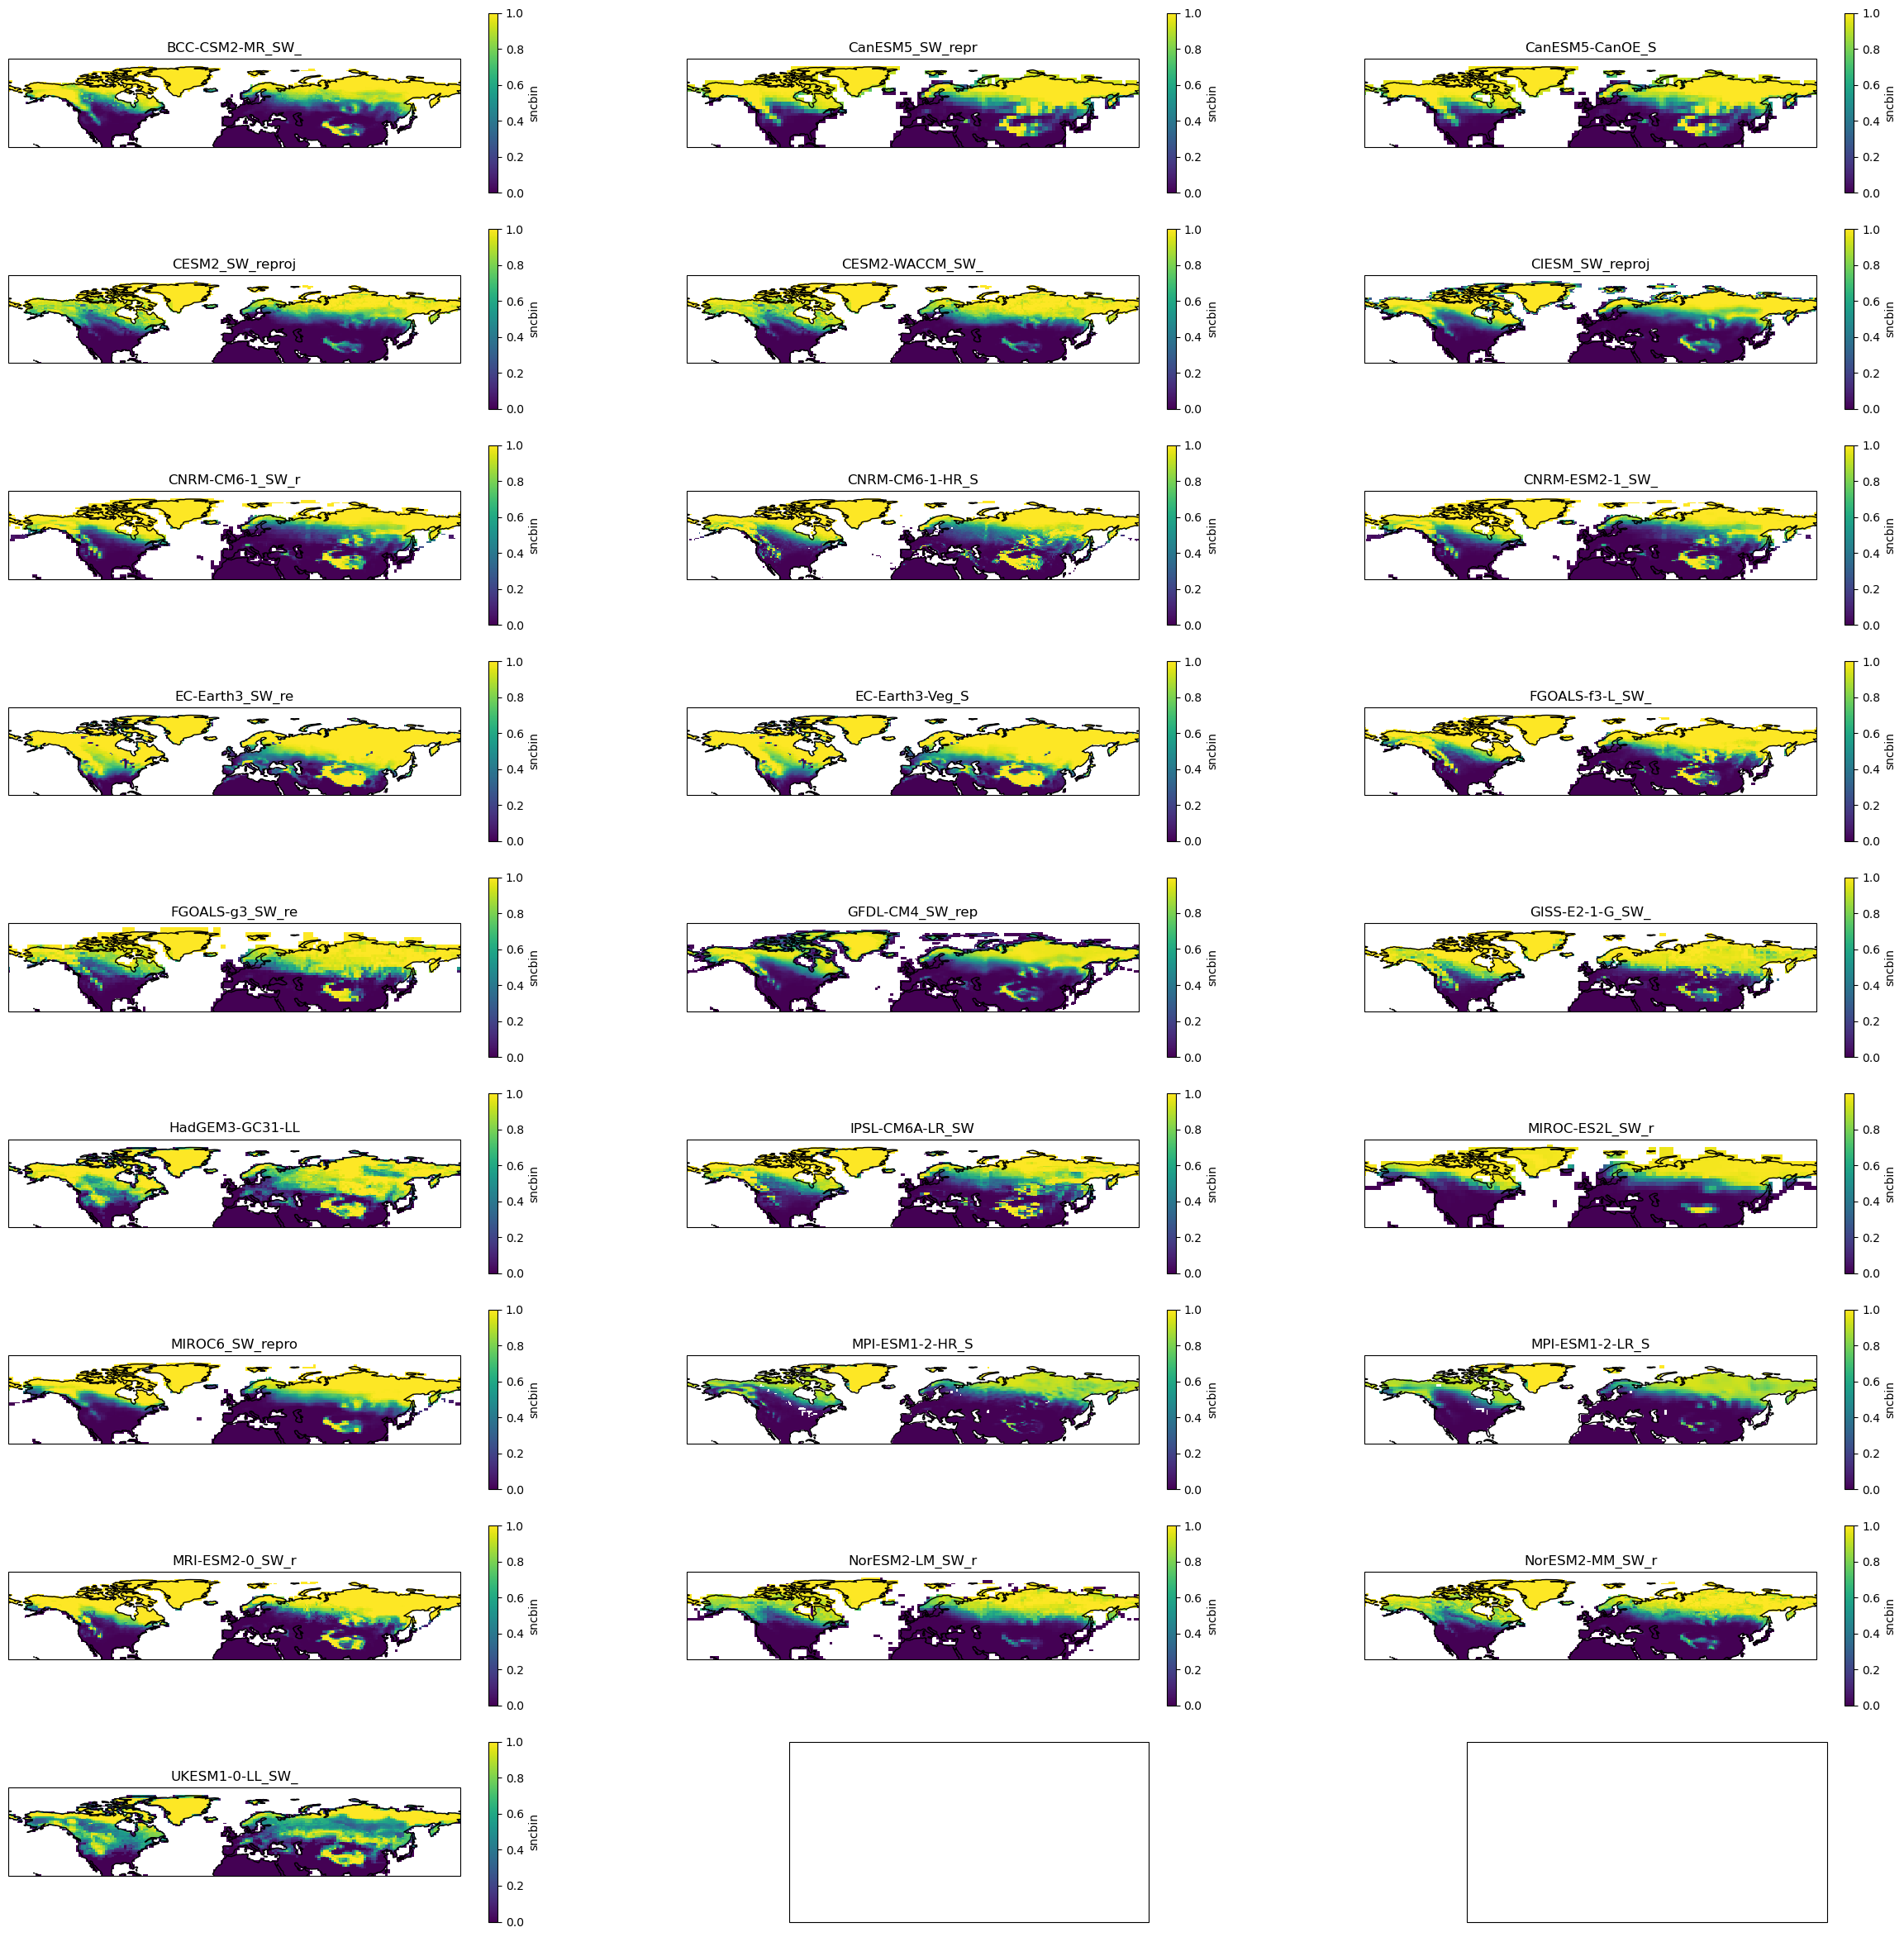

In [10]:
fig, axes = plt.subplots(9, 3, figsize=(30, 30), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

snow_cover_dict = {}

for i, files in enumerate(nc_files):
    model_name = files.split("_")[0]
    
    path_snc = os.path.join("/home/jovyan/private-storage/interp_models_SW/", files)
    path_areacella = os.path.join("/home/jovyan/private-storage/areacella_recalcule_cdo_bis/", files.replace("SW_reprojete", "gridarea_hist_recalcule"))
    path_sftlf = os.path.join("/home/jovyan/private-storage/interp_sftlf_bis/", files.replace("SW", "sftlf"))
                                 
    ds_snc, ds_area, ds_sftlf = get_data(path_snc, path_areacella, path_sftlf)
    sftlf = ds_sftlf["sftlf"]
    snc = extraction_variable_and_limit(ds_snc)
    areacella = ds_area["cell_area"]
    snow_cover_km2 = surface_calculation(snc, areacella)
    snow_cover_dict[model_name] = snow_cover_km2

    ax = axes[i]
    plot_snow_cover(snc, ax=ax, title=files[:15])

    #print(snow_cover_km2)
    
    ds_snc.close()
    ds_area.close()

    #break

In [7]:
print(snow_cover_dict)

{'BCC-CSM2-MR': <xarray.DataArray (month: 12)> Size: 96B
array([42795905.31082872, 43480729.68086886, 40217932.82126354,
       30994260.23288895, 19250432.56153879,  9211745.24584911,
        4900688.70416042,  3882692.94608881,  5438778.03927369,
       15371854.60419859, 28013595.05510664, 37517225.8586485 ])
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    GSAT     float64 8B 0.85, 'CanESM5': <xarray.DataArray (month: 12)> Size: 96B
array([50172193.94479123, 51346405.9670112 , 46545365.22990241,
       37268103.22806188, 23466690.71119136,  9476357.486547  ,
        3957560.60572692,  3443644.28395267,  5803028.84715457,
       17581001.26165996, 33768690.65737879, 44546722.21570148])
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    GSAT     float64 8B 0.85
    type     |S4 4B ..., 'CanESM5-CanOE': <xarray.DataArray (month: 12)> Size: 96B
array([50697638.13489661, 51791544.37146123, 47864355.68906625,
       37994282.62471437, 240

In [20]:
path_snc = os.path.join("~/private-storage/interp_models_SW/", "CanESM5_SW_reprojete.nc") #noms des fichiers à changer en fonction du modèle à visualiser
path_areacella = os.path.join("/home/jovyan/private-storage/areacella_recalcule_cdo_bis/", "CanESM5_gridarea_hist_recalcule.nc")
path_sftlf = os.path.join("/home/jovyan/private-storage/interp_sftlf_bis/", "CanESM5_sftlf_reprojete.nc")
                          
ds_snc, ds_area, ds_sftlf = get_data(path_snc, path_areacella, path_sftlf)
sftlf = ds_sftlf["sftlf"]
snc = extraction_variable_and_limit(ds_snc)
areacella = ds_area["cell_area"]
snow_cover_km2 = surface_calculation(snc, areacella)

La variable 'sncbin' est en %. Conversion en fraction.


In [21]:
ds_snc

<xarray.Dataset> Size: 87MB
Dimensions:  (GSAT: 23, month: 12, lat: 180, lon: 360, Level: 5)
Coordinates:
  * month    (month) float32 48B 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
  * GSAT     (GSAT) float32 92B -0.5 -0.25 0.0 0.25 0.5 ... 4.25 4.5 4.75 5.0
  * Level    (Level) float32 20B 10.0 25.0 50.0 75.0 90.0
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    sncbin   (GSAT, month, lat, lon) float32 72MB ...
    Limit    (Level, month, lat, lon) float32 16MB ...
Attributes:
    regrid_method:  nearest_s2d

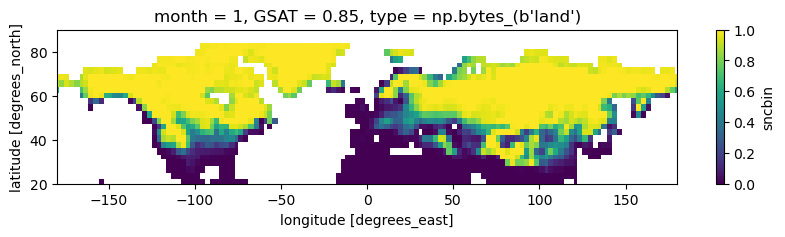

In [22]:
plt.figure(figsize=(10, 2))
snc[0].plot()

In [23]:
snow_cover_km2

<xarray.DataArray (month: 12)> Size: 96B
array([50172193.94479123, 51346405.9670112 , 46545365.22990241,
       37268103.22806188, 23466690.71119136,  9476357.486547  ,
        3957560.60572692,  3443644.28395267,  5803028.84715457,
       17581001.26165996, 33768690.65737879, 44546722.21570148])
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    GSAT     float64 8B 0.85
    type     |S4 4B ...

## Période de référence 1995-2014

### Modification fonction avec GSAT = 0 car période de référence changée

In [5]:
def extraction_variable_and_limit_1995_2014(ds_snc, variable="sncbin", GSAT=0, month=1, lat_min=20):
    snc = (ds_snc[variable]).sel(GSAT=0, month=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]) #je définis ma limite à 0.85°C, pour tous les mois

    #je bloque à 20°N pour n'avoir que l'HN
    if lat_min is not None:
        snc=snc.sel(lat=snc.lat>=lat_min)

    #toutes les valeurs supérieures à 1e19 doivent être considérées comme des NaN
    snc = snc.where(snc < 1e19, float("nan"))

    # verification si exprimé en fraction ou %
    max_val = snc.max().item()
    if max_val > 1.5:
        print(f"La variable '{variable}' est en %. Conversion en fraction.")
        snc = snc / 100

    # snc ne doit être défini que si la fraction terrestre est > 0 donc pas de l'océan
    if sftlf is not None:
        snc = snc.where(sftlf>0)

    # toutes les valeurs de snc doivent être comprises entre 0 et 1
    snc = snc.clip(0, 1)
        
    return snc

### Création d'une liste avec l'ensemble de mes fichiers

In [6]:
files = os.listdir("/home/jovyan/private-storage/output_data/interp_models_SW_1995_2014/")

nc_files = [filename for filename in files if filename.endswith(".nc")]
nc_files

['BCC-CSM2-MR_SW_reprojete.nc',
 'CanESM5_SW_reprojete.nc',
 'CanESM5-CanOE_SW_reprojete.nc',
 'CESM2_SW_reprojete.nc',
 'CESM2-WACCM_SW_reprojete.nc',
 'CIESM_SW_reprojete.nc',
 'CNRM-CM6-1_SW_reprojete.nc',
 'CNRM-CM6-1-HR_SW_reprojete.nc',
 'CNRM-ESM2-1_SW_reprojete.nc',
 'EC-Earth3_SW_reprojete.nc',
 'EC-Earth3-Veg_SW_reprojete.nc',
 'FGOALS-f3-L_SW_reprojete.nc',
 'FGOALS-g3_SW_reprojete.nc',
 'GFDL-CM4_SW_reprojete.nc',
 'GISS-E2-1-G_SW_reprojete.nc',
 'HadGEM3-GC31-LL_SW_reprojete.nc',
 'IPSL-CM6A-LR_SW_reprojete.nc',
 'MIROC-ES2L_SW_reprojete.nc',
 'MIROC6_SW_reprojete.nc',
 'MPI-ESM1-2-HR_SW_reprojete.nc',
 'MPI-ESM1-2-LR_SW_reprojete.nc',
 'MRI-ESM2-0_SW_reprojete.nc',
 'NorESM2-LM_SW_reprojete.nc',
 'NorESM2-MM_SW_reprojete.nc',
 'UKESM1-0-LL_SW_reprojete.nc']

### Création d'une boucle pour que mes fonctions s'applique à tous les fichiers présents dans la liste

La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variabl

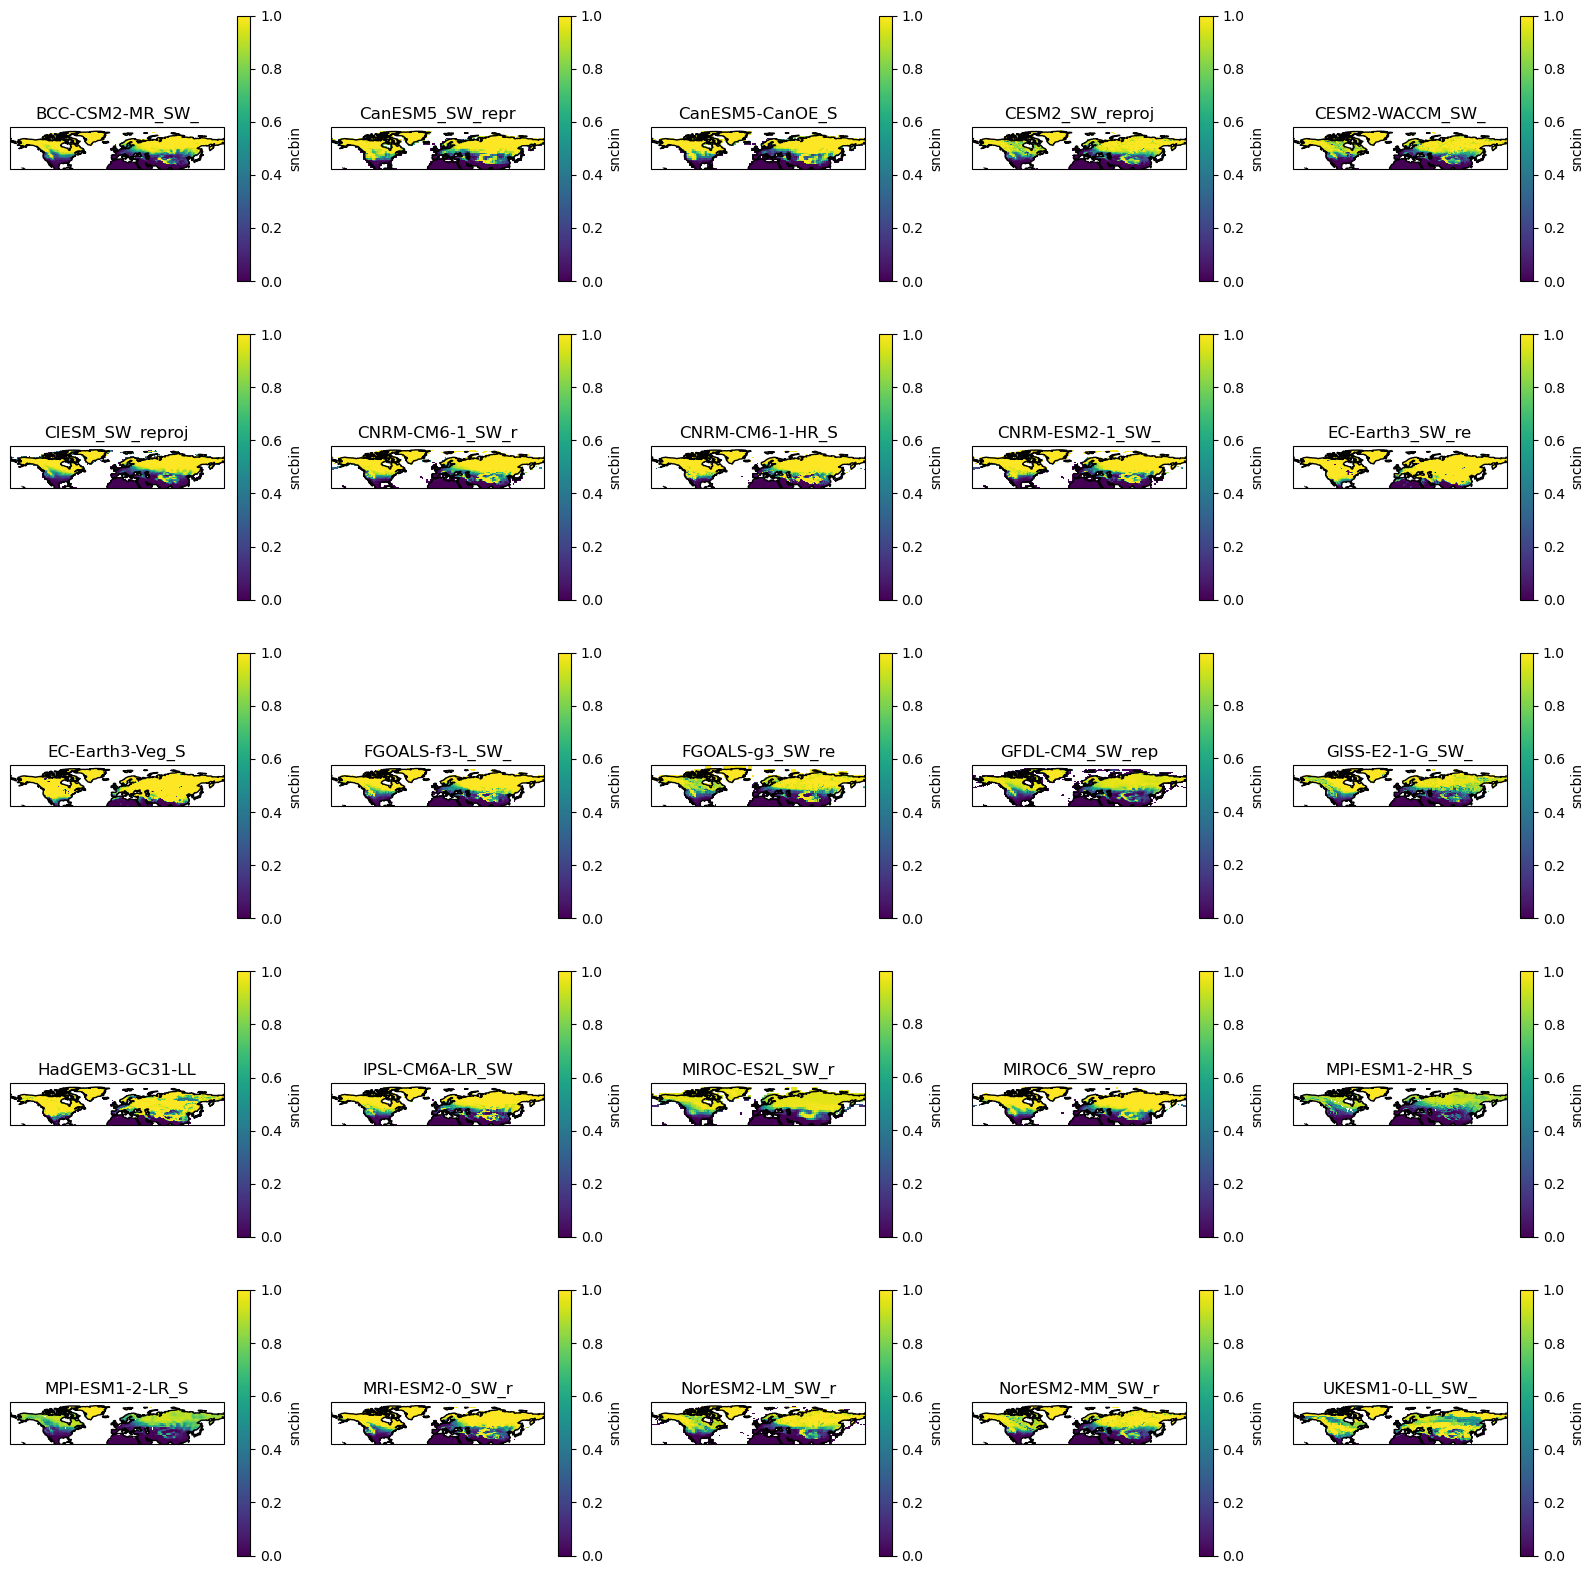

In [7]:
fig, axes = plt.subplots(5, 5, figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

snow_cover_dict = {}

for i, files in enumerate(nc_files):
    model_name = files.split("_")[0]
    
    path_snc = os.path.join("/home/jovyan/private-storage/output_data/interp_models_SW_1995_2014/", files)
    path_areacella = os.path.join("/home/jovyan/private-storage/areacella_recalcule_cdo_bis/", files.replace("SW_reprojete", "gridarea_hist_recalcule"))
    path_sftlf = os.path.join("/home/jovyan/private-storage/interp_sftlf_bis/", files.replace("SW", "sftlf"))
                                 
    ds_snc, ds_area, ds_sftlf = get_data(path_snc, path_areacella, path_sftlf)
    sftlf = ds_sftlf["sftlf"]
    snc = extraction_variable_and_limit_1995_2014(ds_snc)
    areacella = ds_area["cell_area"]
    snow_cover_km2 = surface_calculation(snc, areacella)
    snow_cover_dict[model_name] = snow_cover_km2

    ax = axes[i]
    plot_snow_cover(snc, ax=ax, title=files[:15])

    #print(snow_cover_km2)
    
    ds_snc.close()
    ds_area.close()

    #break

In [9]:
ds_snc

<xarray.Dataset> Size: 87MB
Dimensions:  (GSAT: 23, month: 12, lat: 180, lon: 360, Level: 5)
Coordinates:
  * month    (month) float32 48B 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
  * GSAT     (GSAT) float32 92B -1.5 -1.25 -1.0 -0.75 -0.5 ... 3.25 3.5 3.75 4.0
  * Level    (Level) float32 20B 10.0 25.0 50.0 75.0 90.0
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    sncbin   (GSAT, month, lat, lon) float32 72MB ...
    Limit    (Level, month, lat, lon) float32 16MB ...
Attributes:
    regrid_method:  nearest_s2d

In [8]:
snow_cover_dict

{'BCC-CSM2-MR': <xarray.DataArray (month: 12)> Size: 96B
 array([44112232.89853223, 44346595.84917694, 41243458.16721037,
        32706015.4655839 , 20724486.69622869,  9314200.43265648,
         4782574.71920295,  3852254.76092763,  5483265.08542057,
        15777138.05506192, 27883375.70422506, 38404202.05383761])
 Coordinates:
   * month    (month) float32 48B 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
     GSAT     float32 4B 0.0,
 'CanESM5': <xarray.DataArray (month: 12)> Size: 96B
 array([49894508.50895866, 50870619.56018364, 46870717.457974  ,
        36293500.45722949, 21234119.76381489,  8282672.89108108,
         3382804.61556099,  2854810.37051803,  4791725.39917528,
        16193656.68128264, 32823076.21555386, 43672326.50792691])
 Coordinates:
   * month    (month) float32 48B 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
     GSAT     float32 4B 0.0
     type     |S4 4B ...,
 'CanESM5-CanOE': <xarray.DataArray (month: 12)> Size: 96B
 array([49588068.07454894, 5075206